<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:10px 5px'>Detecting Defects in Steel Sheets with Computer Vision</h1>
</div>

## Setup Environment and Import Data

In [1]:
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
import cv2
import os

from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights, Inception3, Inception_V3_Weights
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.utils.data as utils

In [2]:
#Formatting
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
path = 'Data/'
train_img_path = os.path.join(path, "train_images")
val_img_path = os.path.join(path, "val_images")
train_df_path = os.path.join(path, "train.csv")
val_df_path = os.path.join(path, "val.csv")

In [4]:
df_train = pd.read_csv(train_df_path)
print(len(df_train))
df_train.head()

781


,ImageId,EncodedPixels
0,000f6bf48.jpg,131973 1 132228 4 132483 6 132738 8 132993 11 ...
1,002af848d.jpg,290800 6 291055 13 291311 15 291566 18 291822 ...
2,0030401a5.jpg,186833 1 187089 3 187344 6 187600 7 187855 10 ...
3,008621629.jpg,215548 3 215798 9 216051 12 216306 13 216560 1...
4,012f26693.jpg,35258 2 35513 5 35768 8 36023 11 36277 15 3653...


In [5]:
df_val = pd.read_csv(val_df_path)
print(len(df_val))
df_val.head()

20


,ImageId,EncodedPixels
0,0025bde0c.jpg,315139 8 315395 15 315651 16 315906 17 316162 ...
1,08b40a161.jpg,178410 2 178664 7 178918 11 179172 20 179426 2...
2,1795867f2.jpg,266115 46 266370 51 266625 55 266880 60 267136...
3,190190a6f.jpg,18811 1 19065 5 19320 8 19574 12 19829 15 2008...
4,2fcfb108a.jpg,230653 3 230904 8 231157 11 231413 11 231616 6...


## Helper Functions and Configuration

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Helper Class for Dataloader</h3>
</div>

In [46]:
class ImageData(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
            self.data_path = train_img_path
        elif self.subset == "val":
            self.data_path = val_img_path

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):                      
        fn = self.df['ImageId'].iloc[index]        
        img = Image.open(os.path.join(self.data_path, fn))
        img = self.transform(img)

        if self.subset == 'train': 
            mask = rle2mask(self.df['EncodedPixels'].iloc[index], (256, 1600))
            mask = transforms.ToPILImage()(mask)            
            mask = self.transform(mask)
            return img, mask
        else: 
            mask = None
            return img       

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Helper Function for Decoding Mask</h3>
</div>

In [47]:
#Decoding mask information from EncodedPixels column for training
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Understanding Helper Function for Decoding Mask (Step By Step)</h3>
</div>

In [48]:
#Input to the function = self.df['EncodedPixels'].iloc[index], (256, 1600)

In [49]:
rle = df_train['EncodedPixels'].iloc[0]

In [50]:
imgshape = (256, 1600)

In [51]:
rle

'131973 1 132228 4 132483 6 132738 8 132993 11 133248 13 133503 16 133757 19 134012 22 134267 24 134522 26 134777 29 135032 31 135287 34 135542 36 135796 40 136050 43 136304 46 136558 50 136812 54 137066 56 137320 59 137574 61 137828 63 138082 65 138336 68 138590 70 138845 71 139101 71 139356 73 139612 73 139868 73 140123 74 140379 74 140634 75 140890 75 141145 77 141400 78 141654 80 141909 81 142164 82 142418 84 142673 85 142928 86 143182 88 143437 89 143692 90 143946 93 144201 94 144456 95 144710 97 144965 98 145220 99 145474 101 145729 103 145983 105 146237 107 146491 109 146745 112 146999 114 147253 116 147506 119 147760 122 148014 124 148268 126 148522 128 148776 131 149030 133 149284 135 149539 136 149793 139 150048 140 150303 141 150557 143 150812 145 151067 146 151321 148 151576 149 151831 151 152086 152 152340 155 152595 156 152850 158 153104 161 153359 163 153614 164 153869 166 154125 167 154380 169 154636 169 154891 171 155147 172 155402 174 155658 174 155913 176 156169 177 

In [52]:
width = imgshape[0]
height= imgshape[1]

In [53]:
print(width, height)

256 1600


In [54]:
mask= np.zeros( width*height ).astype(np.uint8)

In [55]:
mask

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [56]:
mask.shape

(409600,)

In [57]:
array = np.asarray([int(x) for x in rle.split()])

In [58]:
array

array([131973,      1, 132228, ...,      2, 289776,      1])

In [59]:
starts = array[0::2]

In [60]:
lengths = array[1::2]


In [61]:
starts.shape

(625,)

In [62]:
for index, start in enumerate(starts):
    mask[int(start):int(start+lengths[index])] = 1

In [63]:
np.sum(mask == 1)

69357

In [64]:
np.sum(lengths)

69357

In [65]:
np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [75]:
# # 
# [
# 0, 1, 0, 1
# 0, 0, 0, 0
# 1, 0, 0, 0
# ]


In [67]:
arr = np.array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [68]:
arr.reshape(3, 4)

array([[0, 0, 1, 1],
       [0, 0, 0, 0],
       [0, 1, 0, 0]])

In [69]:
arr

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [70]:
np.rot90(arr.reshape(4, 3), k = 1)

array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 1]])

In [71]:
np.flipud(np.rot90(arr.reshape(4, 3), k = 1))

array([[0, 1, 0, 1],
       [0, 0, 0, 0],
       [1, 0, 0, 0]])

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Helper Function for Encoding Mask</h3>
</div>

In [72]:
#Encoding mask information from EncodedPixels column
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3)
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Helper Function for Dice Coefficient Calculation</h3>
</div>

In [73]:
def dice_loss(output, target):
    smooth = 1.
    
    output = torch.sigmoid(output)
    iflat = output.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Set Device Configuration</h3>
</div>

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Explore Data

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Explore Data</h3>
</div>

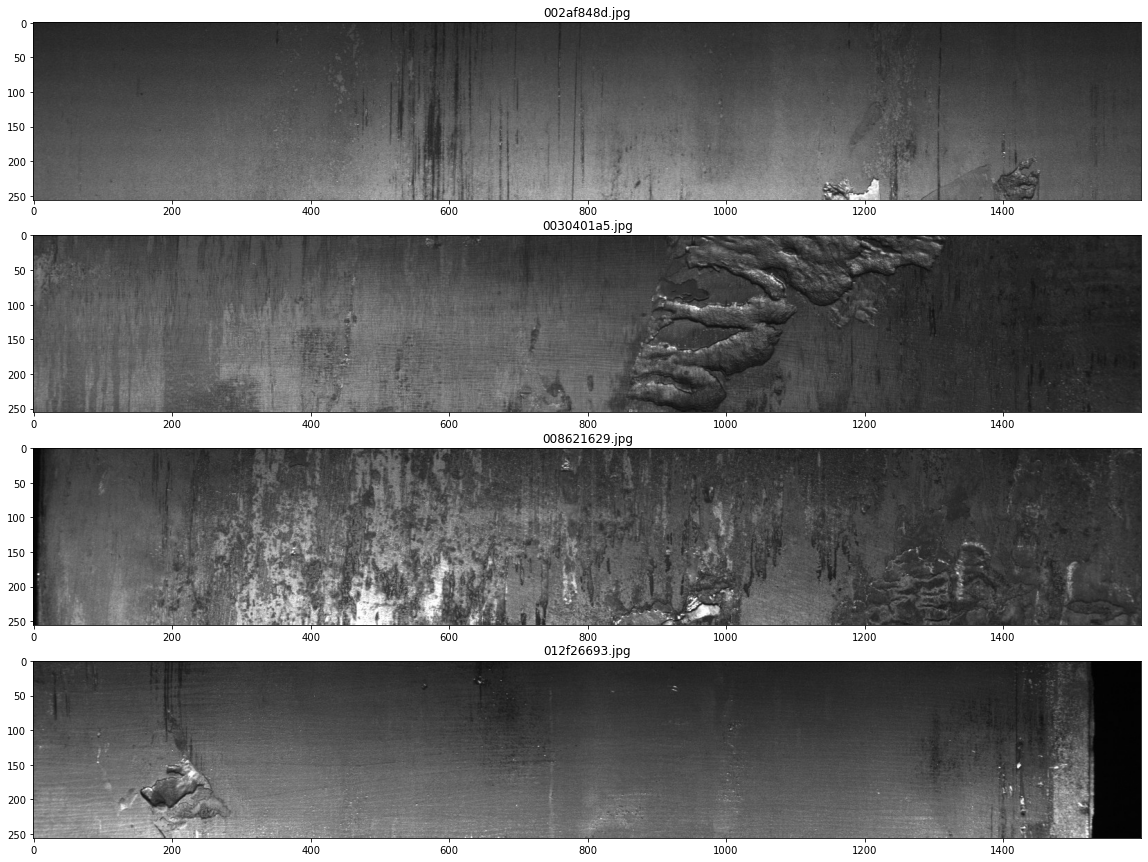

In [119]:
#Display some images without mask
subplot_dims = (4,1)
fig = plt.figure(figsize=(20,15))
for i in range(subplot_dims[0]):
    fn = df_train['ImageId'].iloc[i+1]
    fig.add_subplot(subplot_dims[0], subplot_dims[1], i+1).set_title(fn)
    img = cv2.imread(os.path.join(train_img_path,fn))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

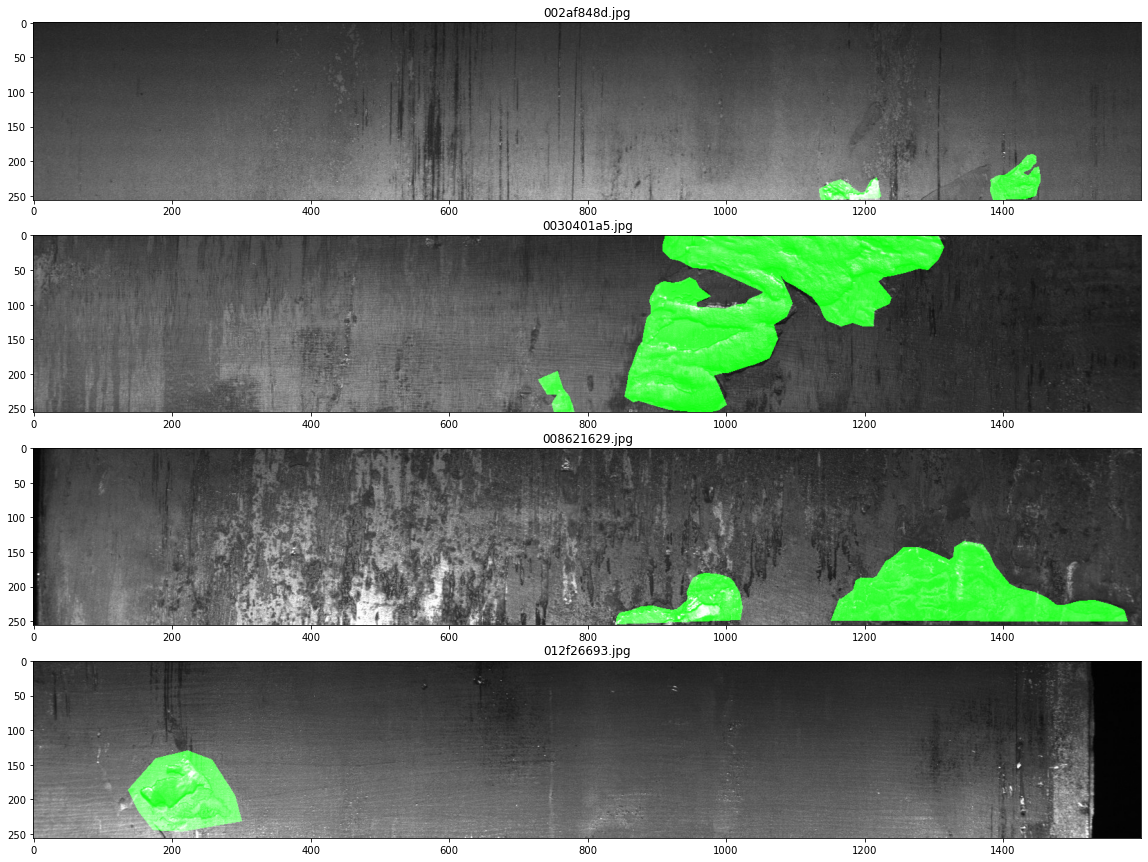

In [120]:
#Display some images with mask
subplot_dims = (4,1)
fig = plt.figure(figsize=(20,15))
for i in range(subplot_dims[0]):
    fn = df_train['ImageId'].iloc[i+1]
    fig.add_subplot(subplot_dims[0], subplot_dims[1], i+1).set_title(fn)
    img = cv2.imread(os.path.join(train_img_path,fn))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    mask = rle2mask(df_train['EncodedPixels'].iloc[i+1], (256, 1600))
    img[mask==1,1] = 255
    plt.imshow(img)
plt.show()

## Train Model

### With BCE Logits Loss

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Define Hyperparameters</h3>
</div>

In [40]:
#Define Hyperparameters 
num_epochs = 5
batch_size = 50
learning_rate = 0.01

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize Dataloader</h3>
</div>

In [41]:
data_transf = transforms.Compose([
                                  transforms.Resize((256, 256)),
                                  transforms.ToTensor()])
train_data = ImageData(df = df_train.loc[:50,:], transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size=batch_size)

In [340]:
print(train_data[4][0].shape, train_data[4][1].shape)

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


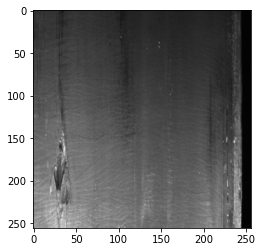

In [341]:
plt.imshow(train_data[4][0].permute(1, 2, 0))

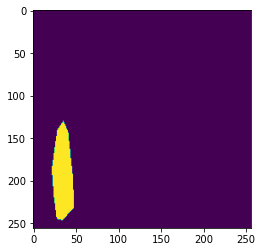

In [342]:
plt.imshow(np.squeeze(train_data[4][1].permute(1, 2, 0)))

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize UNet Model</h3>
</div>

In [343]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        state_dict = torch.hub.load_state_dict_from_url('https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth')
        self.base_model.load_state_dict(state_dict)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [344]:
#Initialize model
model = UNet(n_class=1).to(device)
model

UNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Define Loss and Optimizer</h3>
</div>

In [345]:
#Dice Loss can also be used
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Model Training</h3>
</div>

In [346]:
%%time
# Train the model
total_step = len(train_loader)
average_loss_list = []
#Explicity mention to PyTorch that you're in training mode - good practice
model.train()
for epoch in range(num_epochs):
    loss_epoch = 0
    for i, (X_train_batch, y_train_batch) in enumerate(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        # Forward pass
        y_pred = model(X_train_batch)
        
        # Calculate loss
        loss = criterion(y_pred, y_train_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Add loss
        loss_epoch += loss.item()
        
    average_loss_list.append(loss_epoch/len(train_loader))
    #Show average loss and accuracy per epoch
    if (epoch+1) % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss_epoch/len(train_loader)))

Epoch [1/5], Loss: 488.4250
Epoch [2/5], Loss: 0.1105
Epoch [3/5], Loss: 0.0051
Epoch [4/5], Loss: 0.0044
Epoch [5/5], Loss: 0.0111
CPU times: user 15min 42s, sys: 5min 27s, total: 21min 10s
Wall time: 3min 7s


Text(0, 0.5, 'Log(Loss)')

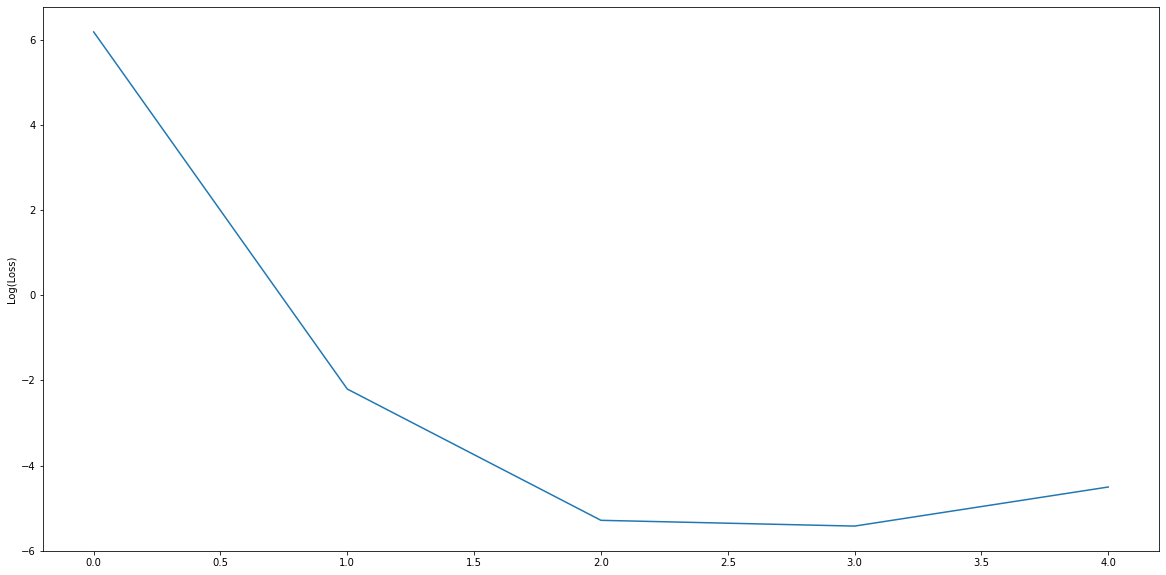

In [347]:
plt.figure(figsize=(20,10))
plt.plot(np.log(average_loss_list))
plt.ylabel("Log(Loss)")

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Model Evaluation</h3>
</div>

**Let's check for one image in training set, whether the model has been fit.**

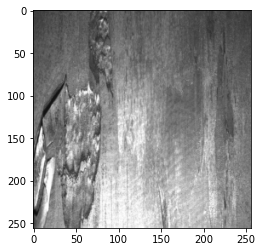

In [348]:
plt.imshow(train_data[5][0].permute(1, 2, 0))

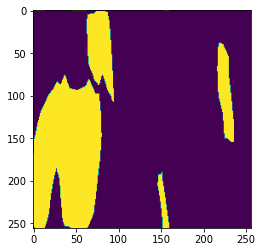

In [349]:
plt.imshow(np.squeeze(train_data[5][1].permute(1, 2, 0)))

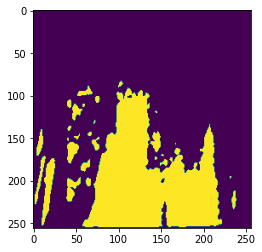

In [350]:
x = train_data[5][0].unsqueeze(0)
o = model(x)  
o = o.detach().numpy() * (-1)
tmp = np.copy(o)
mn = np.mean(o)*1.2
tmp[tmp<mn] = 0
tmp[tmp>mn] = 1
plt.imshow(np.squeeze(tmp))

**Let's check for images in the validation set.**

In [351]:
#Initialize dataloader
val_df = pd.read_csv(val_df_path)
val_data = ImageData(df = val_df, transform = data_transf, subset="val")
val_loader = DataLoader(dataset = val_data, shuffle=False)

In [352]:
#Predict
predict = []
model.eval()
for data in val_loader:
    data = data
    output = model(data)  
    output = output.detach().numpy() * (-1)    
    predict.append(abs(output[0]))

In [353]:
#Resize images
pred_rle = []
  
for p in predict:        
    img = np.copy(p)
    mn = np.mean(img)*1.2
    img[img<=mn] = 0
    img[img>mn] = 1
    img = cv2.resize(img[0], (1600, 256))
    
    pred_rle.append(mask2rle(img))

In [354]:
#Write to dataframe
val_df['EncodedPixels_Prediction'] = pred_rle
val_df.head()

,ImageId,EncodedPixels,EncodedPixels_Prediction
0,0025bde0c.jpg,315139 8 315395 15 315651 16 315906 17 316162 ...,8717 1 8723 7 8733 1 8739 4 8973 1 8979 7 8989...
1,08b40a161.jpg,178410 2 178664 7 178918 11 179172 20 179426 2...,4321 5 4577 5 4833 5 5089 5 5345 5 5601 5 5857...
2,1795867f2.jpg,266115 46 266370 51 266625 55 266880 60 267136...,31334 2 31590 2 31846 2 32102 2 32358 2 32614 ...
3,190190a6f.jpg,18811 1 19065 5 19320 8 19574 12 19829 15 2008...,28154 2 28410 2 28666 2 28922 2 29178 2 29434 ...
4,2fcfb108a.jpg,230653 3 230904 8 231157 11 231413 11 231616 6...,29948 1 30204 1 30460 1 30716 1 30972 1 31228 ...


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Save Model</h3>
</div>

In [358]:
# Save the model checkpoint
torch.save(model.state_dict(), 'Checkpoint/UNet_with_BCELogitsLoss.ckpt')

### With BCE Logits Loss (Entire Data)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Define Hyperparameters</h3>
</div>

In [470]:
#Define Hyperparameters 
num_epochs = 20
batch_size = 50
learning_rate = 0.001

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize Dataloader</h3>
</div>

In [471]:
data_transf = transforms.Compose([
                                  transforms.Resize((256, 256)),
                                  transforms.ToTensor()])
train_data = ImageData(df = df_train, transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size=batch_size)

In [472]:
print(train_data[4][0].shape, train_data[4][1].shape)

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


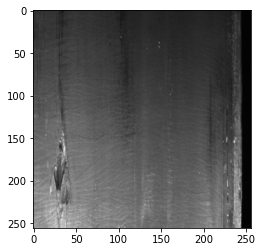

In [473]:
plt.imshow(train_data[4][0].permute(1, 2, 0))

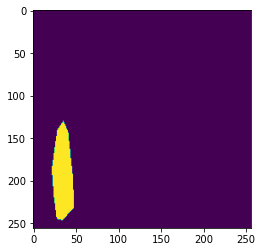

In [474]:
plt.imshow(np.squeeze(train_data[4][1].permute(1, 2, 0)))

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize UNet Model</h3>
</div>

In [475]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        state_dict = torch.hub.load_state_dict_from_url('https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth')
        self.base_model.load_state_dict(state_dict)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [476]:
#Initialize model
model = UNet(n_class=1).to(device)
model

UNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Define Loss and Optimizer</h3>
</div>

In [477]:
#Dice Loss can also be used
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Model Training</h3>
</div>

In [478]:
%%time
# Train the model
total_step = len(train_loader)
average_loss_list = []
#Explicity mention to PyTorch that you're in training mode - good practice
model.train()
for epoch in range(num_epochs):
    loss_epoch = 0
    for i, (X_train_batch, y_train_batch) in enumerate(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        # Forward pass
        y_pred = model(X_train_batch)
        
        # Calculate loss
        loss = criterion(y_pred, y_train_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Add loss and accuracy
        loss_epoch += loss.item()
        
    average_loss_list.append(loss_epoch/len(train_loader))
    #Show average loss and accuracy per epoch
    if (epoch+1) % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss_epoch/len(train_loader)))

Epoch [1/20], Loss: 0.0582
Epoch [2/20], Loss: 0.0033
Epoch [3/20], Loss: 0.0027
Epoch [4/20], Loss: 0.0026
Epoch [5/20], Loss: 0.0025
Epoch [6/20], Loss: 0.0025
Epoch [7/20], Loss: 0.0025
Epoch [8/20], Loss: 0.0024
Epoch [9/20], Loss: 0.0024
Epoch [10/20], Loss: 0.0024
Epoch [11/20], Loss: 0.0024
Epoch [12/20], Loss: 0.0024
Epoch [13/20], Loss: 0.0024
Epoch [14/20], Loss: 0.0023
Epoch [15/20], Loss: 0.0023
Epoch [16/20], Loss: 0.0023
Epoch [17/20], Loss: 0.0023
Epoch [18/20], Loss: 0.0023
Epoch [19/20], Loss: 0.0023
Epoch [20/20], Loss: 0.0023
CPU times: user 17h 40min 36s, sys: 6h 28min 49s, total: 1d 9min 25s
Wall time: 3h 35min 18s


Text(0, 0.5, 'Log(Loss)')

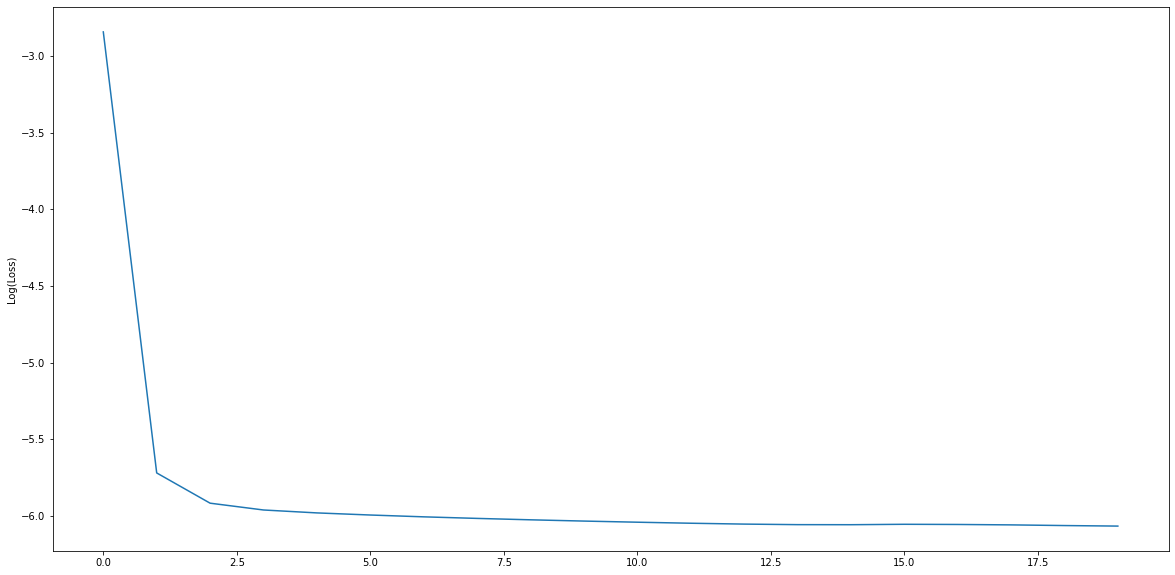

In [479]:
plt.figure(figsize=(20,10))
plt.plot(np.log(average_loss_list))
plt.ylabel("Log(Loss)")

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Model Evaluation</h3>
</div>

**Let's check for one image in training set, whether the model has been fit.**

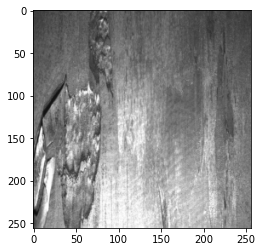

In [480]:
plt.imshow(train_data[5][0].permute(1, 2, 0))

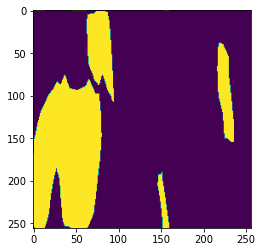

In [481]:
plt.imshow(np.squeeze(train_data[5][1].permute(1, 2, 0)))

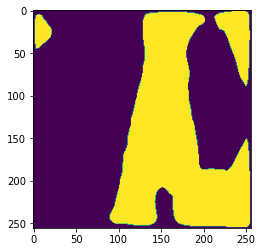

In [482]:
x = train_data[5][0].unsqueeze(0)
o = model(x)  
o = o.detach().numpy() * (-1)
tmp = np.copy(o)
mn = np.mean(o)*1.2
tmp[tmp<mn] = 0
tmp[tmp>mn] = 1
plt.imshow(np.squeeze(tmp))

**Let's check for images in the validation set.**

In [483]:
#Initialize dataloader
val_df = pd.read_csv(val_df_path)
val_data = ImageData(df = val_df, transform = data_transf, subset="val")
val_loader = DataLoader(dataset = val_data, shuffle=False)

In [484]:
#Predict
predict = []
model.eval()
for data in val_loader:
    data = data
    output = model(data)  
    output = output.detach().numpy() * (-1)    
    predict.append(abs(output[0]))

In [485]:
#Resize images
pred_rle = []
  
for p in predict:        
    img = np.copy(p)
    mn = np.mean(img)*1.2
    img[img<=mn] = 0
    img[img>mn] = 1
    img = cv2.resize(img[0], (1600, 256))
    
    pred_rle.append(mask2rle(img))

In [486]:
#Write to dataframe
val_df['EncodedPixels_Prediction'] = pred_rle
val_df.head()

,ImageId,EncodedPixels,EncodedPixels_Prediction
0,0025bde0c.jpg,315139 8 315395 15 315651 16 315906 17 316162 ...,15238 24 15494 24 15750 24 16006 24 16262 24 1...
1,08b40a161.jpg,178410 2 178664 7 178918 11 179172 20 179426 2...,71408 9 71664 9 71920 9 72176 9 72432 9 72688 ...
2,1795867f2.jpg,266115 46 266370 51 266625 55 266880 60 267136...,15212 21 15468 21 15724 21 15980 21 16236 21 1...
3,190190a6f.jpg,18811 1 19065 5 19320 8 19574 12 19829 15 2008...,138737 3 138993 3 139249 3 139505 3 139761 3 1...
4,2fcfb108a.jpg,230653 3 230904 8 231157 11 231413 11 231616 6...,4296 38 4552 38 4808 38 5064 38 5320 38 5576 3...


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Save Model</h3>
</div>

In [490]:
# Save the model checkpoint
torch.save(model.state_dict(), 'Checkpoint/UNet_with_BCELogitsLoss_EntireData.ckpt')

### With BCE Logits Loss with LR Scheduler

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Define Hyperparameters</h3>
</div>

In [424]:
#Define Hyperparameters 
num_epochs = 15
batch_size = 50
learning_rate = 0.001
#For Learning Rate Scheduler
step_size = 4
gamma = 0.5

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize Dataloader</h3>
</div>

In [426]:
data_transf = transforms.Compose([
                                  transforms.Resize((256, 256)),
                                  transforms.ToTensor()])
train_data = ImageData(df = df_train.loc[:100,:], transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size=batch_size)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize UNet Model</h3>
</div>

In [427]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        state_dict = torch.hub.load_state_dict_from_url('https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth')
        self.base_model.load_state_dict(state_dict)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [428]:
#Initialize model
model = UNet(n_class=1).to(device)
model

UNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Define Loss and Optimizer</h3>
</div>

In [429]:
#Using BCE Logits loss with learning rate scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Model Training</h3>
</div>

In [430]:
%%time
# Train the model
total_step = len(train_loader)
average_loss_list = []
#Explicity mention to PyTorch that you're in training mode - good practice
model.train()
for epoch in range(num_epochs):
    loss_epoch = 0
    for i, (X_train_batch, y_train_batch) in enumerate(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        # Forward pass
        y_pred = model(X_train_batch)
        
        # Calculate loss
        loss = criterion(y_pred, y_train_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Add loss and accuracy
        loss_epoch += loss.item()
    
    scheduler.step()
    average_loss_list.append(loss_epoch/len(train_loader))
    #Show average loss and accuracy per epoch
    if (epoch+1) % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss_epoch/len(train_loader)))

Epoch [1/15], Loss: 0.2588
Epoch [2/15], Loss: 0.0150
Epoch [3/15], Loss: 0.0126
Epoch [4/15], Loss: 0.0121
Epoch [5/15], Loss: 0.0052
Epoch [6/15], Loss: 0.0037
Epoch [7/15], Loss: 0.0041
Epoch [8/15], Loss: 0.0036
Epoch [9/15], Loss: 0.0034
Epoch [10/15], Loss: 0.0034
Epoch [11/15], Loss: 0.0033
Epoch [12/15], Loss: 0.0032
Epoch [13/15], Loss: 0.0032
Epoch [14/15], Loss: 0.0032
Epoch [15/15], Loss: 0.0032
CPU times: user 2h 47min 45s, sys: 40min 53s, total: 3h 28min 38s
Wall time: 32min 3s


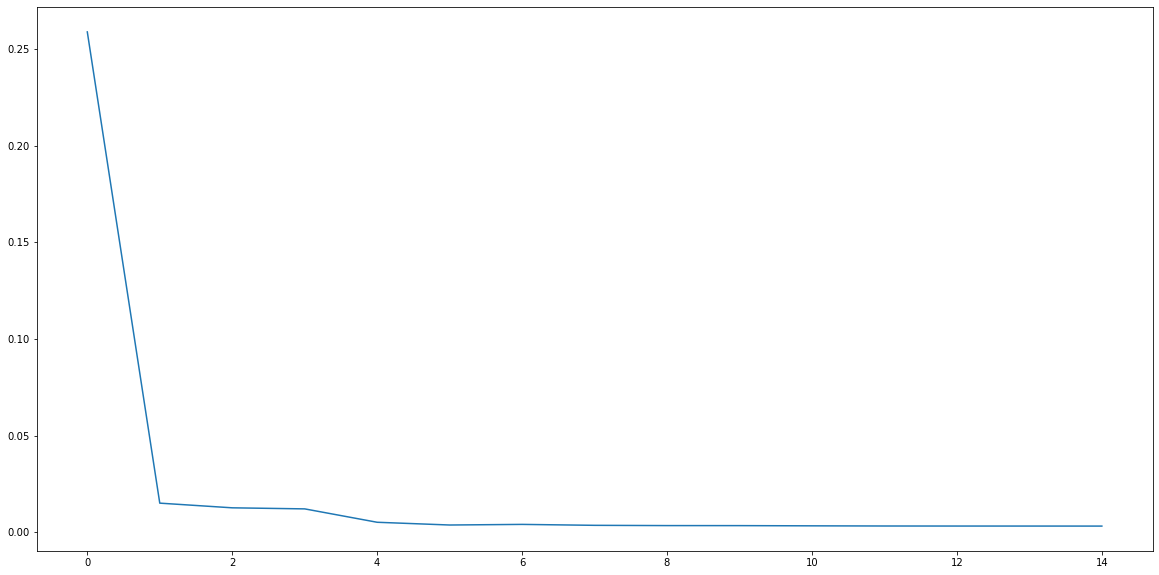

In [431]:
plt.figure(figsize=(20,10))
plt.plot(average_loss_list)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Model Evaluation</h3>
</div>

**Let's check for one image in training set, whether the model has been fit.**

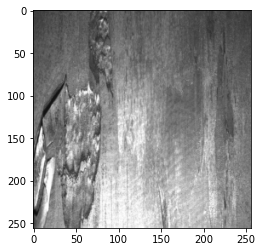

In [432]:
plt.imshow(train_data[5][0].permute(1, 2, 0))

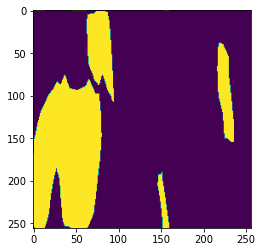

In [433]:
plt.imshow(np.squeeze(train_data[5][1].permute(1, 2, 0)))

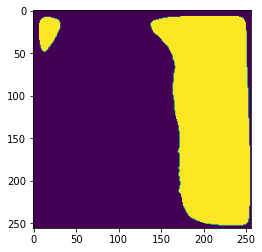

In [434]:
x = train_data[5][0].unsqueeze(0)
o = model(x)  
o = o.detach().numpy() * (-1)
tmp = np.copy(o)
mn = np.mean(o)*1.2
tmp[tmp<mn] = 0
tmp[tmp>mn] = 1
plt.imshow(np.squeeze(tmp))

**Let's check for images in the validation set.**

In [435]:
#Initialize dataloader
val_df = pd.read_csv(val_df_path)
val_data = ImageData(df = val_df, transform = data_transf, subset="val")
val_loader = DataLoader(dataset = val_data, shuffle=False)

In [436]:
#Predict
predict = []
model.eval()
for data in val_loader:
    data = data
    output = model(data)  
    output = output.detach().numpy() * (-1)    
    predict.append(abs(output[0]))

In [437]:
#Resize images
pred_rle = []
  
for p in predict:        
    img = np.copy(p)
    mn = np.mean(img)*1.2
    img[img<=mn] = 0
    img[img>mn] = 1
    img = cv2.resize(img[0], (1600, 256))
    
    pred_rle.append(mask2rle(img))

In [438]:
#Write to dataframe
val_df['EncodedPixels_Prediction'] = pred_rle
val_df.head()

,ImageId,EncodedPixels,EncodedPixels_Prediction
0,0025bde0c.jpg,315139 8 315395 15 315651 16 315906 17 316162 ...,12228 7 12484 7 12740 7 12996 7 13252 7 13508 ...
1,08b40a161.jpg,178410 2 178664 7 178918 11 179172 20 179426 2...,7247 148 7503 148 7759 148 8015 148 8271 148 8...
2,1795867f2.jpg,266115 46 266370 51 266625 55 266880 60 267136...,7302 70 7558 70 7814 70 8070 70 8326 70 8582 7...
3,190190a6f.jpg,18811 1 19065 5 19320 8 19574 12 19829 15 2008...,87509 13 87765 13 88021 13 88277 13 88533 13 8...
4,2fcfb108a.jpg,230653 3 230904 8 231157 11 231413 11 231616 6...,305048 29 305304 29 305560 29 305816 29 306072...


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Save Model</h3>
</div>

In [442]:
# Save the model checkpoint
torch.save(model.state_dict(), 'Checkpoint/UNet_with_BCELogitsLoss_LR.ckpt')

### With DICE Loss

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Define Hyperparameters</h3>
</div>

In [297]:
#Define Hyperparameters 
num_epochs = 5
batch_size = 50
learning_rate = 0.001

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize Dataloader</h3>
</div>

In [298]:
data_transf = transforms.Compose([
                                  transforms.Resize((256, 256)),
                                  transforms.ToTensor()])
train_data = ImageData(df = df_train.loc[:100,:], transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size=batch_size)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize UNet Model</h3>
</div>

In [299]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        state_dict = torch.hub.load_state_dict_from_url('https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth')
        self.base_model.load_state_dict(state_dict)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [300]:
#Initialize model
model = UNet(n_class=1).to(device)
model

UNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Define Loss and Optimizer</h3>
</div>

In [302]:
#Dice Loss to be used
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Model Training</h3>
</div>

In [303]:
%%time
# Train the model
total_step = len(train_loader)
average_loss_list = []
#Explicity mention to PyTorch that you're in training mode - good practice
model.train()
for epoch in range(num_epochs):
    loss_epoch = 0
    for i, (X_train_batch, y_train_batch) in enumerate(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        # Forward pass
        y_pred = model(X_train_batch)
        
        # Calculate loss
        loss = dice_loss(y_pred, y_train_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Add loss and accuracy
        loss_epoch += loss.item()
        
    average_loss_list.append(loss_epoch/len(train_loader))
    #Show average loss and accuracy per epoch
    if (epoch+1) % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss_epoch/len(train_loader)))

Epoch [1/5], Loss: 0.9992
Epoch [2/5], Loss: 0.9991
Epoch [3/5], Loss: 0.9971
Epoch [4/5], Loss: 0.9895
Epoch [5/5], Loss: 0.9895
CPU times: user 37min 18s, sys: 12min 10s, total: 49min 28s
Wall time: 7min 29s


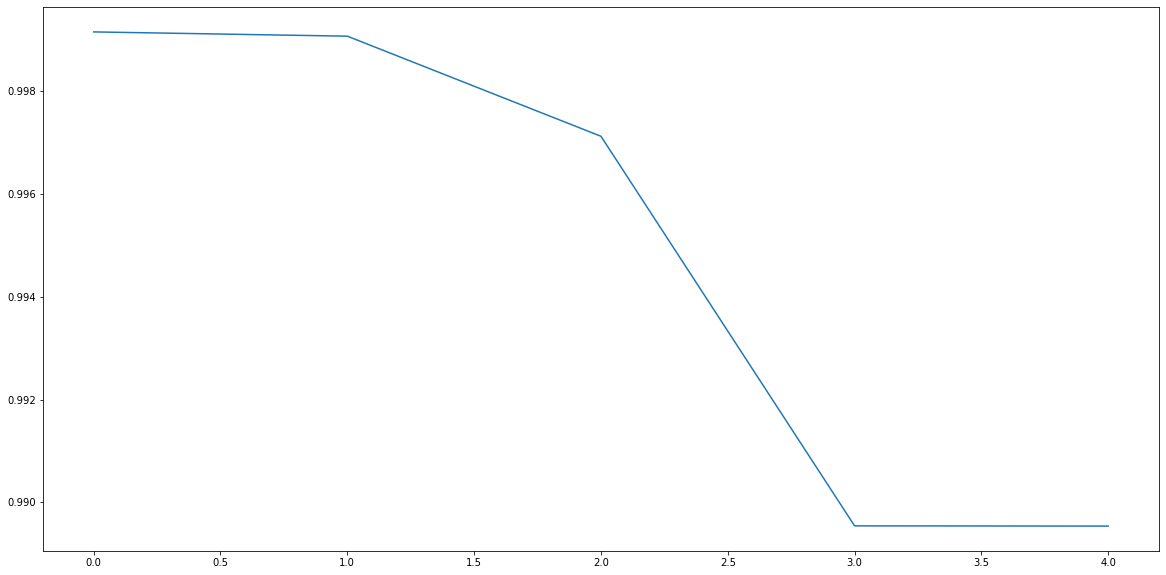

In [304]:
plt.figure(figsize=(20,10))
plt.plot(average_loss_list)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Model Evaluation</h3>
</div>

**Let's check for one image in training set, whether the model has been fit.**

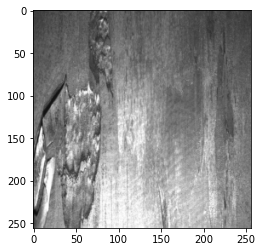

In [305]:
plt.imshow(train_data[5][0].permute(1, 2, 0))

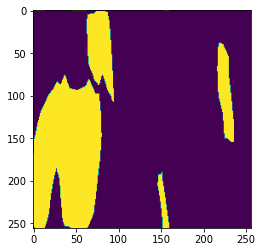

In [306]:
plt.imshow(np.squeeze(train_data[5][1].permute(1, 2, 0)))

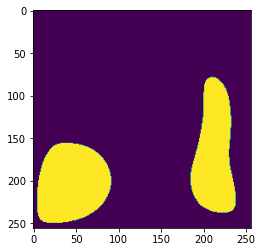

In [307]:
x = train_data[5][0].unsqueeze(0)
o = model(x)  
o = o.detach().numpy() * (-1)
tmp = np.copy(o)
mn = np.mean(o)*1.2
tmp[tmp<mn] = 0
tmp[tmp>mn] = 1
plt.imshow(np.squeeze(tmp))

**Let's check for images in the validation set.**

In [308]:
#Initialize dataloader
val_df = pd.read_csv(val_df_path)
val_data = ImageData(df = val_df, transform = data_transf, subset="val")
val_loader = DataLoader(dataset = val_data, shuffle=False)

In [309]:
#Predict
predict = []
model.eval()
for data in val_loader:
    data = data
    output = model(data)  
    output = output.detach().numpy() * (-1)    
    predict.append(abs(output[0]))

In [310]:
#Resize images
pred_rle = []
  
for p in predict:        
    img = np.copy(p)
    mn = np.mean(img)*1.2
    img[img<=mn] = 0
    img[img>mn] = 1
    img = cv2.resize(img[0], (1600, 256))
    
    pred_rle.append(mask2rle(img))

In [311]:
#Write to dataframe
val_df['EncodedPixels_Prediction'] = pred_rle
val_df.head()

,ImageId,EncodedPixels,EncodedPixels_Prediction
0,0025bde0c.jpg,315139 8 315395 15 315651 16 315906 17 316162 ...,2319 35 2575 35 2831 35 3087 35 3343 35 3599 3...
1,08b40a161.jpg,178410 2 178664 7 178918 11 179172 20 179426 2...,5645 29 5901 29 6157 29 6413 29 6669 29 6925 2...
2,1795867f2.jpg,266115 46 266370 51 266625 55 266880 60 267136...,274472 34 274728 34 274984 34 275240 34 275496...
3,190190a6f.jpg,18811 1 19065 5 19320 8 19574 12 19829 15 2008...,281018 37 281274 37 281530 37 281786 37 282042...
4,2fcfb108a.jpg,230653 3 230904 8 231157 11 231413 11 231616 6...,8722 25 8978 25 9234 25 9490 25 9746 25 10002 ...


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Save Model</h3>
</div>

In [315]:
# Save the model checkpoint
torch.save(model.state_dict(), 'Checkpoint/UNet_with_Dice.ckpt')

### With DICE Loss with LR Scheduler

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Define Hyperparameters</h3>
</div>

In [382]:
#Define Hyperparameters 
num_epochs = 15
batch_size = 50
learning_rate = 0.001
#For Learning Rate Scheduler
step_size = 4
gamma = 0.5

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize Dataloader</h3>
</div>

In [383]:
data_transf = transforms.Compose([
                                  transforms.Resize((256, 256)),
                                  transforms.ToTensor()])
train_data = ImageData(df = df_train.loc[:100,:], transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size=batch_size)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize UNet Model</h3>
</div>

In [384]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        state_dict = torch.hub.load_state_dict_from_url('https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth')
        self.base_model.load_state_dict(state_dict)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [385]:
#Initialize model
model = UNet(n_class=1).to(device)
model

UNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Define Loss and Optimizer</h3>
</div>

In [386]:
#Using Dice loss with learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Model Training</h3>
</div>

In [387]:
%%time
# Train the model
total_step = len(train_loader)
average_loss_list = []
#Explicity mention to PyTorch that you're in training mode - good practice
model.train()
for epoch in range(num_epochs):
    loss_epoch = 0
    for i, (X_train_batch, y_train_batch) in enumerate(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        # Forward pass
        y_pred = model(X_train_batch)
        
        # Calculate loss
        loss = dice_loss(y_pred, y_train_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Add loss and accuracy
        loss_epoch += loss.item()
    
    scheduler.step()
    average_loss_list.append(loss_epoch/len(train_loader))
    #Show average loss and accuracy per epoch
    if (epoch+1) % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss_epoch/len(train_loader)))

Epoch [1/15], Loss: 0.9991
Epoch [2/15], Loss: 0.9992
Epoch [3/15], Loss: 0.9992
Epoch [4/15], Loss: 0.9992
Epoch [5/15], Loss: 0.9991
Epoch [6/15], Loss: 0.9991
Epoch [7/15], Loss: 0.9989
Epoch [8/15], Loss: 0.9980
Epoch [9/15], Loss: 0.9969
Epoch [10/15], Loss: 0.9956
Epoch [11/15], Loss: 0.9945
Epoch [12/15], Loss: 0.9930
Epoch [13/15], Loss: 0.9906
Epoch [14/15], Loss: 0.9900
Epoch [15/15], Loss: 0.9897
CPU times: user 1h 39min 53s, sys: 37min 13s, total: 2h 17min 7s
Wall time: 20min 28s


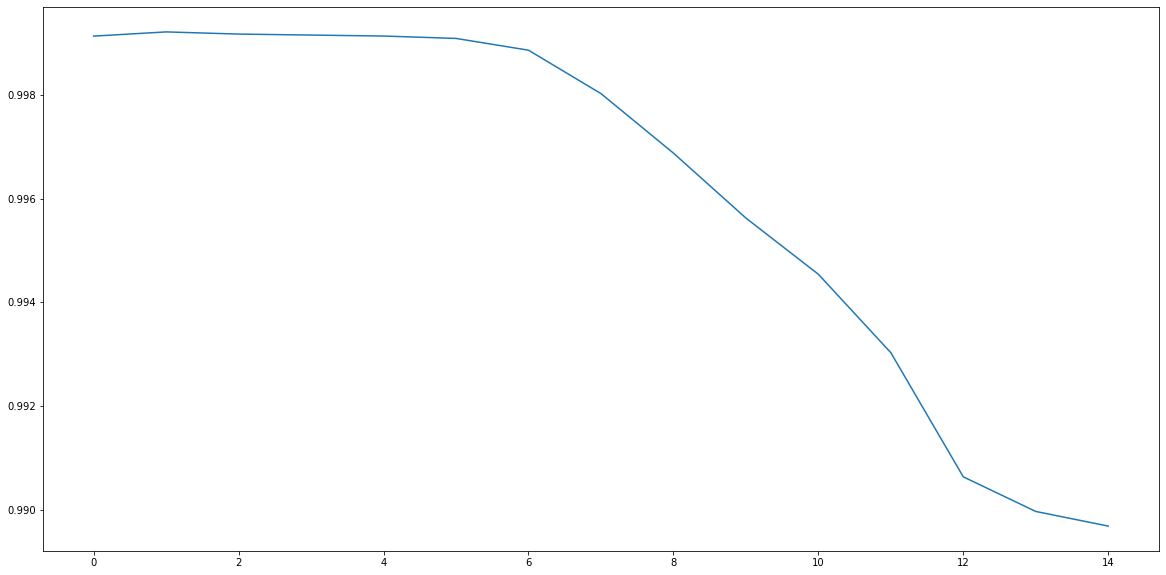

In [388]:
plt.figure(figsize=(20,10))
plt.plot(average_loss_list)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Model Evaluation</h3>
</div>

**Let's check for one image in training set, whether the model has been fit.**

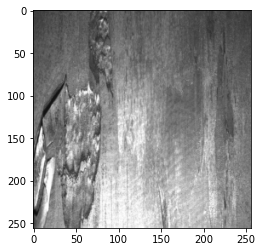

In [400]:
plt.imshow(train_data[5][0].permute(1, 2, 0))

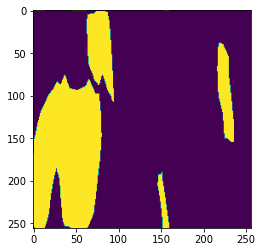

In [401]:
plt.imshow(np.squeeze(train_data[5][1].permute(1, 2, 0)))

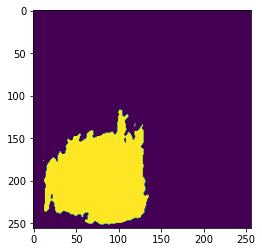

In [402]:
x = train_data[5][0].unsqueeze(0)
o = model(x)  
o = o.detach().numpy() * (-1)
tmp = np.copy(o)
mn = np.mean(o)*1.2
tmp[tmp<mn] = 0
tmp[tmp>mn] = 1
plt.imshow(np.squeeze(tmp))

**Let's check for images in the validation set.**

In [403]:
#Initialize dataloader
val_df = pd.read_csv(val_df_path)
val_data = ImageData(df = val_df, transform = data_transf, subset="val")
val_loader = DataLoader(dataset = val_data, shuffle=False)

In [404]:
#Predict
predict = []
model.eval()
for data in val_loader:
    data = data
    output = model(data)  
    output = output.detach().numpy() * (-1)    
    predict.append(abs(output[0]))

In [405]:
#Resize images
pred_rle = []
  
for p in predict:        
    img = np.copy(p)
    mn = np.mean(img)*1.2
    img[img<=mn] = 0
    img[img>mn] = 1
    img = cv2.resize(img[0], (1600, 256))
    
    pred_rle.append(mask2rle(img))

In [406]:
#Write to dataframe
val_df['EncodedPixels_Prediction'] = pred_rle
val_df.head()

,ImageId,EncodedPixels,EncodedPixels_Prediction
0,0025bde0c.jpg,315139 8 315395 15 315651 16 315906 17 316162 ...,26594 4 26850 4 27106 4 27362 4 27618 4 27874 ...
1,08b40a161.jpg,178410 2 178664 7 178918 11 179172 20 179426 2...,32793 5 33049 5 33305 5 33561 5 33817 5 34073 ...
2,1795867f2.jpg,266115 46 266370 51 266625 55 266880 60 267136...,
3,190190a6f.jpg,18811 1 19065 5 19320 8 19574 12 19829 15 2008...,
4,2fcfb108a.jpg,230653 3 230904 8 231157 11 231413 11 231616 6...,132326 6 132334 2 132582 6 132590 2 132838 6 1...


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Save Model</h3>
</div>

In [416]:
# Save the model checkpoint
torch.save(model.state_dict(), 'Checkpoint/UNet_with_Dice_LR.ckpt')

### With DICE Loss with LR Scheduler (Entire Data)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Define Hyperparameters</h3>
</div>

In [492]:
#Define Hyperparameters 
num_epochs = 15
batch_size = 50
learning_rate = 0.001
#For Learning Rate Scheduler
step_size = 4
gamma = 0.5

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize Dataloader</h3>
</div>

In [493]:
data_transf = transforms.Compose([
                                  transforms.Resize((256, 256)),
                                  transforms.ToTensor()])
train_data = ImageData(df = df_train, transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size=batch_size)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize UNet Model</h3>
</div>

In [494]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        state_dict = torch.hub.load_state_dict_from_url('https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth')
        self.base_model.load_state_dict(state_dict)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [495]:
#Initialize model
model = UNet(n_class=1).to(device)
model

UNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Define Loss and Optimizer</h3>
</div>

In [496]:
#Using Dice loss with learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Model Training</h3>
</div>

In [497]:
%%time
# Train the model
total_step = len(train_loader)
average_loss_list = []
#Explicity mention to PyTorch that you're in training mode - good practice
model.train()
for epoch in range(num_epochs):
    loss_epoch = 0
    for i, (X_train_batch, y_train_batch) in enumerate(train_loader):
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        # Forward pass
        y_pred = model(X_train_batch)
        
        # Calculate loss
        loss = dice_loss(y_pred, y_train_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #Add loss and accuracy
        loss_epoch += loss.item()
    
    scheduler.step()
    average_loss_list.append(loss_epoch/len(train_loader))
    #Show average loss and accuracy per epoch
    if (epoch+1) % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss_epoch/len(train_loader)))

Epoch [1/15], Loss: 0.9974
Epoch [2/15], Loss: 0.9980
Epoch [3/15], Loss: 0.9990
Epoch [4/15], Loss: 0.9990
Epoch [5/15], Loss: 0.9990
Epoch [6/15], Loss: 0.9990
Epoch [7/15], Loss: 0.9990
Epoch [8/15], Loss: 0.9990
Epoch [9/15], Loss: 0.9990
Epoch [10/15], Loss: 0.9990
Epoch [11/15], Loss: 0.9990
Epoch [12/15], Loss: 0.9990
Epoch [13/15], Loss: 0.9990
Epoch [14/15], Loss: 0.9990
Epoch [15/15], Loss: 0.9990
CPU times: user 13h 18min 13s, sys: 4h 22min 50s, total: 17h 41min 3s
Wall time: 2h 36min 14s


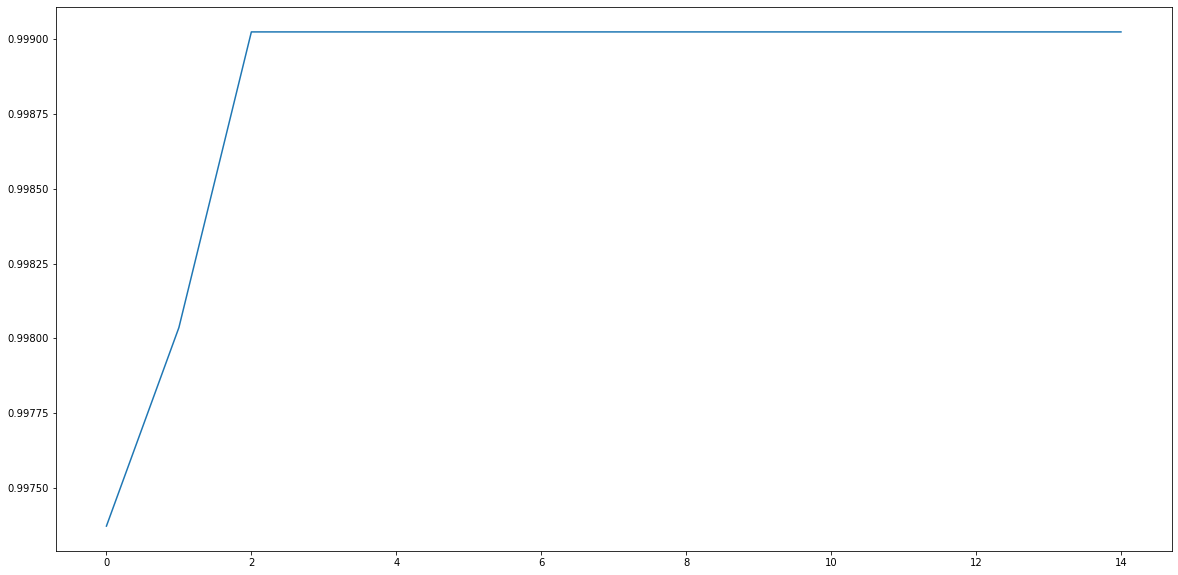

In [498]:
plt.figure(figsize=(20,10))
plt.plot(average_loss_list)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Model Evaluation</h3>
</div>

**Let's check for one image in training set, whether the model has been fit.**

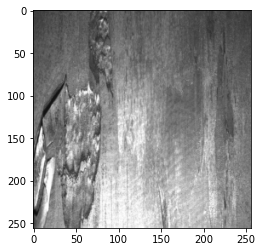

In [499]:
plt.imshow(train_data[5][0].permute(1, 2, 0))

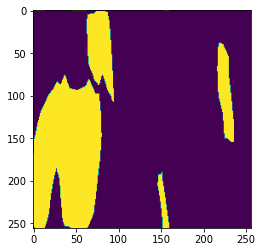

In [500]:
plt.imshow(np.squeeze(train_data[5][1].permute(1, 2, 0)))

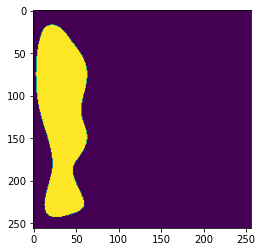

In [501]:
x = train_data[5][0].unsqueeze(0)
o = model(x)  
o = o.detach().numpy() * (-1)
tmp = np.copy(o)
mn = np.mean(o)*1.2
tmp[tmp<mn] = 0
tmp[tmp>mn] = 1
plt.imshow(np.squeeze(tmp))

**Let's check for images in the validation set.**

In [502]:
#Initialize dataloader
val_df = pd.read_csv(val_df_path)
val_data = ImageData(df = val_df, transform = data_transf, subset="val")
val_loader = DataLoader(dataset = val_data, shuffle=False)

In [503]:
#Predict
predict = []
model.eval()
for data in val_loader:
    data = data
    output = model(data)  
    output = output.detach().numpy() * (-1)    
    predict.append(abs(output[0]))

In [504]:
#Resize images
pred_rle = []
  
for p in predict:        
    img = np.copy(p)
    mn = np.mean(img)*1.2
    img[img<=mn] = 0
    img[img>mn] = 1
    img = cv2.resize(img[0], (1600, 256))
    
    pred_rle.append(mask2rle(img))

In [505]:
#Write to dataframe
val_df['EncodedPixels_Prediction'] = pred_rle
val_df.head()

,ImageId,EncodedPixels,EncodedPixels_Prediction
0,0025bde0c.jpg,315139 8 315395 15 315651 16 315906 17 316162 ...,4176 34 4432 34 4688 34 4944 34 5200 34 5456 3...
1,08b40a161.jpg,178410 2 178664 7 178918 11 179172 20 179426 2...,79327 6 79583 6 79839 6 80095 6 80351 6 80607 ...
2,1795867f2.jpg,266115 46 266370 51 266625 55 266880 60 267136...,
3,190190a6f.jpg,18811 1 19065 5 19320 8 19574 12 19829 15 2008...,21569 25 21825 25 22081 25 22337 25 22593 25 2...
4,2fcfb108a.jpg,230653 3 230904 8 231157 11 231413 11 231616 6...,39386 10 39642 10 39898 10 40154 10 40410 10 4...


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Save Model</h3>
</div>

In [509]:
# Save the model checkpoint
torch.save(model.state_dict(), 'Checkpoint/UNet_with_Dice_LR_EntireData.ckpt')

## Visualize with TensorBoard

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Define Hyperparameters</h3>
</div>

In [642]:
#Define Hyperparameters 
num_epochs = 5
batch_size = 1
learning_rate = 0.01

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize Dataloader</h3>
</div>

In [643]:
data_transf = transforms.Compose([
                                  transforms.Resize((256, 256)),
                                  transforms.ToTensor()])
train_data = ImageData(df = df_train.loc[:5,:], transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size=batch_size)

In [644]:
print(train_data[4][0].shape, train_data[4][1].shape)

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


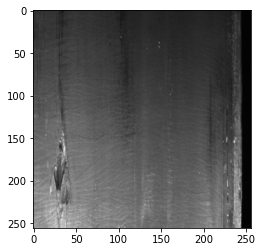

In [645]:
plt.imshow(train_data[4][0].permute(1, 2, 0))

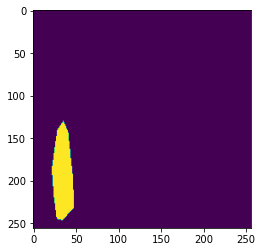

In [646]:
plt.imshow(np.squeeze(train_data[4][1].permute(1, 2, 0)))

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize UNet Model</h3>
</div>

In [44]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        state_dict = torch.hub.load_state_dict_from_url('https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth')
        self.base_model.load_state_dict(state_dict)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [76]:
#Initialize model
model = UNet(n_class=1).to(device)
model

UNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Initialize Writer</h3>
</div>

In [37]:
writer = SummaryWriter('Tensorboard')

/Users/anantagarwal/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Show Images in TensorBoard</h3>
</div>

In [38]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

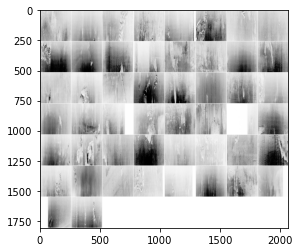

In [42]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('steel-defect-images', img_grid)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'>Show Model Architecture in TensorBoard</h3>
</div>

In [77]:
writer.add_graph(model, images)
writer.close()